In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from copy import deepcopy as dc
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
#investigating the data
data = pd.read_csv('/kaggle/input/google-stock-prediction/GOOG.csv')
data 

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.470,713.1200,716.48,1306065,718.27,722.470,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.980,717.3100,719.00,1214517,718.92,722.980,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.650,703.2600,714.91,1982471,710.36,716.650,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.820,688.4515,708.65,3402357,691.72,708.820,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.480,693.4100,698.77,2082538,693.71,702.480,693.4100,698.77,2082538,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,GOOG,2021-06-07 00:00:00+00:00,2466.09,2468.000,2441.0725,2451.32,1192453,2466.09,2468.000,2441.0725,2451.32,1192453,0.0,1.0
1254,GOOG,2021-06-08 00:00:00+00:00,2482.85,2494.495,2468.2400,2479.90,1253253,2482.85,2494.495,2468.2400,2479.90,1253253,0.0,1.0
1255,GOOG,2021-06-09 00:00:00+00:00,2491.40,2505.000,2487.3300,2499.50,1006337,2491.40,2505.000,2487.3300,2499.50,1006337,0.0,1.0
1256,GOOG,2021-06-10 00:00:00+00:00,2521.60,2523.260,2494.0000,2494.01,1561733,2521.60,2523.260,2494.0000,2494.01,1561733,0.0,1.0


In [4]:
data = data[['date','adjClose']]
data

,date,adjClose
0,2016-06-14 00:00:00+00:00,718.27
1,2016-06-15 00:00:00+00:00,718.92
2,2016-06-16 00:00:00+00:00,710.36
3,2016-06-17 00:00:00+00:00,691.72
4,2016-06-20 00:00:00+00:00,693.71
...,...,...
1253,2021-06-07 00:00:00+00:00,2466.09
1254,2021-06-08 00:00:00+00:00,2482.85
1255,2021-06-09 00:00:00+00:00,2491.40
1256,2021-06-10 00:00:00+00:00,2521.60


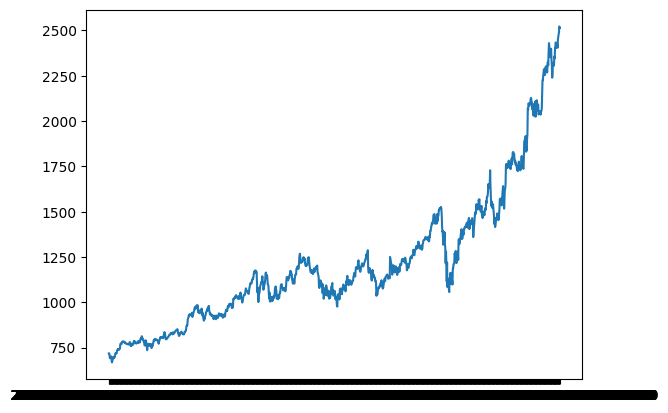

In [5]:
plt.plot(data['date'], data['adjClose'])

In [6]:
#getting weekly closure
def prepare_dataframe_for_lstm(df, n_steps):
  df = dc(df)
  df['date'] = pd.to_datetime(df['date'])

  df.set_index('date', inplace=True)

  for i in range(1, n_steps+1):
    df[f'close(t-{i})'] = df['adjClose'].shift(i)

  df.dropna(inplace=True)

  return df

In [7]:
lookback = 5
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,adjClose,close(t-1),close(t-2),close(t-3),close(t-4),close(t-5)
date,,,,,,
2016-06-21 00:00:00+00:00,695.94,693.71,691.72,710.36,718.92,718.27
2016-06-22 00:00:00+00:00,697.46,695.94,693.71,691.72,710.36,718.92
2016-06-23 00:00:00+00:00,701.87,697.46,695.94,693.71,691.72,710.36
2016-06-24 00:00:00+00:00,675.22,701.87,697.46,695.94,693.71,691.72
2016-06-27 00:00:00+00:00,668.26,675.22,701.87,697.46,695.94,693.71
...,...,...,...,...,...,...
2021-06-07 00:00:00+00:00,2466.09,2451.76,2404.61,2421.28,2429.81,2411.56
2021-06-08 00:00:00+00:00,2482.85,2466.09,2451.76,2404.61,2421.28,2429.81
2021-06-09 00:00:00+00:00,2491.40,2482.85,2466.09,2451.76,2404.61,2421.28


In [8]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 695.94,  693.71,  691.72,  710.36,  718.92,  718.27],
       [ 697.46,  695.94,  693.71,  691.72,  710.36,  718.92],
       [ 701.87,  697.46,  695.94,  693.71,  691.72,  710.36],
       ...,
       [2491.4 , 2482.85, 2466.09, 2451.76, 2404.61, 2421.28],
       [2521.6 , 2491.4 , 2482.85, 2466.09, 2451.76, 2404.61],
       [2513.93, 2521.6 , 2491.4 , 2482.85, 2466.09, 2451.76]])

In [9]:
scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.9701296 , -0.97253607, -0.97426418, -0.95359833, -0.94364317,
        -0.94391926],
       [-0.96848932, -0.9701296 , -0.97208113, -0.97414292, -0.95316576,
        -0.94319036],
       [-0.96373035, -0.96848932, -0.96963481, -0.97194959, -0.97390187,
        -0.95278946],
       ...,
       [ 0.96741019,  0.9581836 ,  0.97223472,  0.96573331,  0.93160644,
         0.96582002],
       [ 1.        ,  0.96741019,  0.99062058,  0.98152751,  0.98405856,
         0.94712644],
       [ 0.99172305,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ]])

In [10]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((1253, 5), (1253,))

In [11]:
X = dc(np.flip(X,axis=1))
X

array([[-0.94391926, -0.94364317, -0.95359833, -0.97426418, -0.97253607],
       [-0.94319036, -0.95316576, -0.97414292, -0.97208113, -0.9701296 ],
       [-0.95278946, -0.97390187, -0.97194959, -0.96963481, -0.96848932],
       ...,
       [ 0.96582002,  0.93160644,  0.96573331,  0.97223472,  0.9581836 ],
       [ 0.94712644,  0.98405856,  0.98152751,  0.99062058,  0.96741019],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ]])

In [12]:
split_index = int(len(X) * 0.95) #95% train, 5% test
split_index

1190

In [13]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1190, 5), (63, 5), (1190,), (63,))

In [14]:
#reshaping the data
X_train = X_train.reshape((-1,lookback,1))
X_test = X_test.reshape((-1,lookback,1))

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1190, 5, 1), (63, 5, 1), (1190, 1), (63, 1))

In [15]:
#creating tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1190, 5, 1]),
 torch.Size([63, 5, 1]),
 torch.Size([1190, 1]),
 torch.Size([63, 1]))

In [16]:
#creating tensor dataset
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [17]:
#creating batches from the new dataset
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [18]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device) #our device?
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([8, 5, 1]) torch.Size([8, 1])


In [19]:
#creating lstm model
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_layers = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                        batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_layers).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_layers).to(device)
    out, _ =self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

model = LSTM(1,4,1)
model.to(device)
model


LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [20]:
#epochs training function
def train_one_epoch():
  model.train(True)
  print(f'Epoch: {epoch + 1}')
  running_loss = 0.0

  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 100 == 99: #print every 100 batches
      avg_loss_across_batches = running_loss / 100
      print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                             avg_loss_across_batches))
      running_loss = 0.0
  print()

In [21]:
#epochs evaluation function
def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss

    avg_loss_across_batches = running_loss/len(test_loader)

    print('Val Loss : {0:.3f}'.format(avg_loss_across_batches))
    print('*****************************')
    print()

In [22]:
learning_rate = 0.001
num_epochs = 70
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  train_one_epoch()
  validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.183

Val Loss : 0.060
*****************************

Val Loss : 0.129
*****************************

Val Loss : 0.226
*****************************

Val Loss : 0.330
*****************************

Val Loss : 0.448
*****************************

Val Loss : 0.549
*****************************

Val Loss : 0.674
*****************************

Val Loss : 0.814
*****************************

Epoch: 2
Batch 100, Loss: 0.035

Val Loss : 0.029
*****************************

Val Loss : 0.065
*****************************

Val Loss : 0.123
*****************************

Val Loss : 0.187
*****************************

Val Loss : 0.263
*****************************

Val Loss : 0.324
*****************************

Val Loss : 0.405
*****************************

Val Loss : 0.500
*****************************

Epoch: 3
Batch 100, Loss: 0.009

Val Loss : 0.015
*****************************

Val Loss : 0.036
*****************************

Val Loss : 0.074
********************

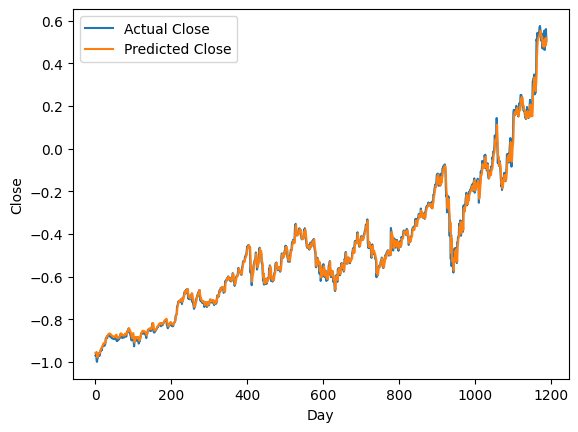

In [23]:
with torch.no_grad():
  predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [24]:
#unscaling the values
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:,0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:,0])
train_predictions

array([ 707.54131008,  707.62592831,  708.64123669, ..., 2043.82825607,
       2047.34814275, 2076.96204018])

In [25]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:,0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:,0])
new_y_train

array([ 695.93999513,  697.45997507,  701.87001025, ..., 2055.03000945,
       2114.76998768, 2061.91998864])

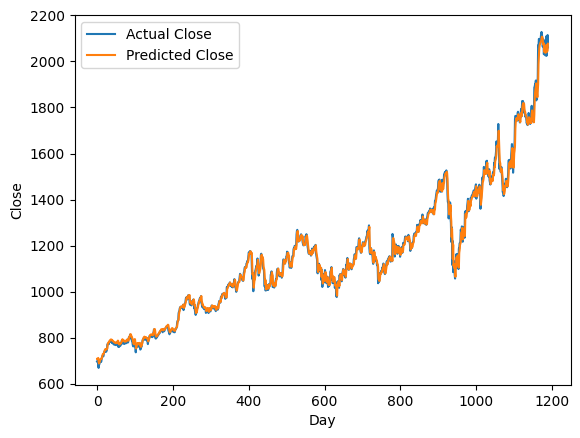

In [26]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [27]:
#checking the model on the test data
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_test.shape[0],lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:,0])
test_predictions

array([2061.43685828, 2061.25353717, 2073.60415435, 2078.21750528,
       2051.12171844, 2045.26582712, 2039.60789388, 2042.31777635,
       2038.15833709, 2037.80649755, 2033.13056668, 2041.73124825,
       2044.30536595, 2052.2968183 , 2088.94861114, 2144.01840282,
       2169.8548582 , 2195.46838981, 2216.69050005, 2234.8130531 ,
       2230.91757634, 2234.65547097, 2231.41689022, 2244.36950097,
       2250.29029204, 2256.48018236, 2256.92000939, 2258.11814177,
       2248.53634157, 2260.01840667, 2269.11210545, 2267.77533615,
       2291.29296462, 2319.40107721, 2328.30631815, 2329.98537154,
       2320.74187858, 2314.41771481, 2315.97039318, 2321.63926272,
       2308.0856526 , 2291.79492972, 2258.56050956, 2246.93373181,
       2256.66449767, 2263.58916371, 2262.26587146, 2266.78350215,
       2284.6380054 , 2288.83577695, 2310.15808136, 2323.35714549,
       2338.12032139, 2337.28921786, 2340.41379597, 2345.5021579 ,
       2345.94049362, 2341.02131294, 2351.81947268, 2361.14565

In [28]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:,0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([2066.48998101, 2092.51997575, 2091.07997441, 2036.21998846,
       2043.1999988 , 2038.58998951, 2052.96001097, 2045.05999823,
       2044.35999221, 2035.55000202, 2055.95001184, 2055.54001108,
       2068.63001599, 2137.75002522, 2225.55000737, 2224.75000049,
       2249.68001338, 2265.43999432, 2285.87999344, 2254.79002697,
       2267.27000178, 2254.84001359, 2296.65998125, 2297.76001833,
       2302.39999197, 2293.63001869, 2293.2899992 , 2267.91999357,
       2315.30002011, 2326.73999702, 2307.11999944, 2379.91002091,
       2429.89001459, 2410.1200019 , 2395.17002517, 2354.2499824 ,
       2356.73997897, 2381.35002225, 2398.69002231, 2341.65998179,
       2308.7600025 , 2239.07997741, 2261.9699838 , 2316.16001094,
       2321.40998707, 2303.42999255, 2308.71001588, 2356.08998719,
       2345.10000034, 2406.66998603, 2409.07000668, 2433.52997962,
       2402.50999442, 2411.56000325, 2429.80998076, 2421.2799985 ,
       2404.60998487, 2451.76001772, 2466.08999465, 2482.84998

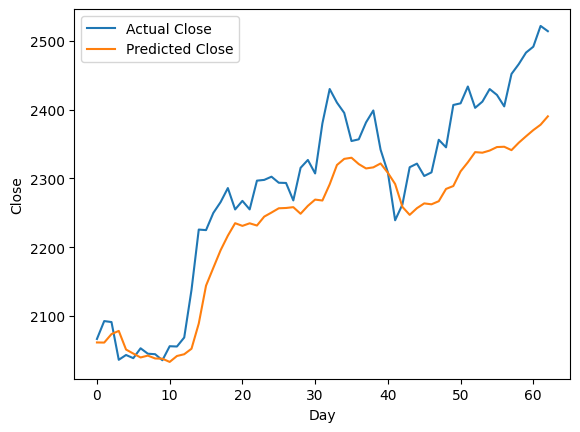

In [29]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()